# Exercise 4 Spark MLlib (MultiLayer perceptron classifier)


## Introduction
Today you’ll learn about Spark MLlib How to perform operations and train learners using Spark MLlib
Sources:

1. https://spark.apache.org/

2. https://spark.apache.org/docs/latest/ml-classification-regression.html

3. https://github.com/Apress/learn-pyspark

4. https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier



## Reading input data

Input data file source: https://github.com/Apress/learn-pyspark/blob/master/chap_8/dl_data.csv


In [1]:
import os
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as f
from pyspark.sql.functions import udf, StringType
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer

#Building session now
spark =SparkSession.builder.appName('deep_learning_with_spark').getOrCreate()

#Reading the file now
data = spark.read.csv('/home/jovyan/dl_data.csv', header=True, inferSchema=True)

## Exploring schema

Now, we will check the data types of parameters present in the read file. Also, if there is categorical data, how should we proceed with it?

In [2]:
data.dtypes
data.show()

+-------------------+---------------------+-----------------+-------------------------------------+-------------------------------+-----------------------+------------------------------+-------------------------------+-------------------------+-------------------------+-------------------+------------------+-------------------+-----------------+------------------+------------------+-------------------------+
|Visit_Number_Bucket|Page_Views_Normalized|Orders_Normalized|Internal_Search_Successful_Normalized|Internal_Search_Null_Normalized|Email_Signup_Normalized|Total_Seconds_Spent_Normalized|Store_Locator_Search_Normalized|Mapped_Last_Touch_Channel|Mapped_Mobile_Device_Type|Mapped_Browser_Type|Mapped_Entry_Pages|Mapped_Site_Section|Mapped_Promo_Code|Maped_Product_Name|Mapped_Search_Term|Mapped_Product_Collection|
+-------------------+---------------------+-----------------+-------------------------------------+-------------------------------+-----------------------+---------------------

## Rename the column

In [3]:
data = data.withColumnRenamed("Orders_normalized", "label")

# Check the updated schema
data.printSchema()

root
 |-- Visit_Number_Bucket: string (nullable = true)
 |-- Page_Views_Normalized: double (nullable = true)
 |-- label: integer (nullable = true)
 |-- Internal_Search_Successful_Normalized: double (nullable = true)
 |-- Internal_Search_Null_Normalized: double (nullable = true)
 |-- Email_Signup_Normalized: double (nullable = true)
 |-- Total_Seconds_Spent_Normalized: double (nullable = true)
 |-- Store_Locator_Search_Normalized: double (nullable = true)
 |-- Mapped_Last_Touch_Channel: string (nullable = true)
 |-- Mapped_Mobile_Device_Type: string (nullable = true)
 |-- Mapped_Browser_Type: string (nullable = true)
 |-- Mapped_Entry_Pages: string (nullable = true)
 |-- Mapped_Site_Section: string (nullable = true)
 |-- Mapped_Promo_Code: string (nullable = true)
 |-- Maped_Product_Name: string (nullable = true)
 |-- Mapped_Search_Term: string (nullable = true)
 |-- Mapped_Product_Collection: string (nullable = true)



## Train, Validation and test split

In [4]:
train, validation, test = data.randomSplit([0.7, 0.2, 0.1], seed=1234)

 ## Building the pipeline

In [5]:
categorical_columns = [item[0] for item in data.dtypes if item[1].startswith('string')]
numeric_columns = [item[0] for item in data.dtypes if item[1].startswith('double')]
indexers = [StringIndexer(inputCol=column, outputCol='{0}_index'.format(column)) for column in categorical_columns]

#Now we will building string indexer to further create the feature set from our data
featuresCreator = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numeric_columns, outputCol="features")

#Configure the classifier
layers = [len(featuresCreator.getInputCols()), 4, 2, 2]
classifier = MultilayerPerceptronClassifier(labelCol='label', featuresCol='features', maxIter=100, layers=layers, blockSize=128, seed=1234)

#Now are pipeline is configured so we can further move to fitting and prediction
pipeline = Pipeline(stages=indexers + [featuresCreator, classifier])
model = pipeline.fit(train)

## Let's checkout the results

In [6]:
train_output_df = model.transform(train)
validation_output_df = model.transform(validation)
test_output_df = model.transform(test)

In [7]:
train_predictionAndLabels = train_output_df.select("prediction", "label")
validation_predictionAndLabels = validation_output_df.select("prediction", "label")
test_predictionAndLabels = test_output_df.select("prediction", "label")
metrics = ['weightedPrecision', 'weightedRecall', 'accuracy']
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Train ' + metric + ' = ' + str(evaluator.evaluate(train_predictionAndLabels)))
    print('Validation ' + metric + ' = ' + str(evaluator.evaluate(validation_predictionAndLabels)))
    print('Test ' + metric + ' = ' + str(evaluator.evaluate(test_predictionAndLabels)))

Train weightedPrecision = 0.9779044413197855
Validation weightedPrecision = 0.9784763194570193
Test weightedPrecision = 0.9794300151810532
Train weightedRecall = 0.9777107847904308
Validation weightedRecall = 0.9783262682893477
Test weightedRecall = 0.9793177544990599
Train accuracy = 0.9777107847904308
Validation accuracy = 0.9783262682893478
Test accuracy = 0.9793177544990599


## Plots and visualizations

Confusion matrix, without normalization
[[3760  104]
 [  50 3532]]


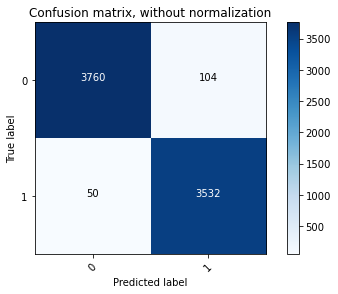

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#Get Class labels
class_temp = test_predictionAndLabels.select("label").groupBy("label").count().sort('count', ascending=False).toPandas()["label"].tolist()

#Calculate confusion matrix
from sklearn.metrics import confusion_matrix
y_true = test_predictionAndLabels.select("label")
y_true = y_true.toPandas()
y_pred = test_predictionAndLabels.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
    
#Plotting Results
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp, title='Confusion matrix, without normalization')
plt.show()


## Questions for the Exercise 4 report:

Please answer the following questions. Compile your answers into a 1 page report, put
there your student ID number and your name.
1. What have you learned today?
2. Put results of steps 6 and 7. Explain what you have got there.